# 22 dimensional toy system setup with a keras/tensorflow RCmodel
This notebook will show you the basic usage of aimmd, you will learn how to:
- set up an ANN-enhanced TPS simulation of a 22 dimensional toy system (of which only 2 are relevant degrees of freedom)
- run the simulation
- inspect the training process
- (try to) analyze what the ANN learned

Note that this notebook is essentially identical to `1_Toy_pytorch_simple_setup.ipynb` except that here we use a keras/tensorflow model to learn the committor.

In [1]:
# needed to be able to run multiple notebooks in paralell, depending on your tensorflow version:
# tell tf to not grab the whole GPU memory available
import tensorflow as tf
if tf.version.VERSION.startswith('2.'):
    # tell tf to use only the GPU mem it needs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print('available GPUs: ', gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.keras import backend as K

else:
    conf = tf.compat.v1.ConfigProto()
    conf.gpu_options.allow_growth = True
    conf.gpu_options.per_process_gpu_memory_fraction = 0.25
    #tf.enable_eager_execution(config=conf)\n",
    sess = tf.compat.v1.Session(config=conf)
    from tensorflow.keras import backend as K
    K.set_session(sess)

available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Imports, working directory and logging setup

In [2]:
%matplotlib inline

In [3]:
import os
import aimmd
import numpy as np
import matplotlib.pyplot as plt
import openpathsampling as paths
# convenience for the toy dynamics
import openpathsampling.engines.toy as toys
from functools import reduce

In [4]:
# load a helper class for visualization of the toy system
%run resources/toy_plot_helpers.py

In [5]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets for openpathsampling
%run resources/logconf.py

In [6]:
# set working directory
# set to None to use current folder (where the notebook is located)
wdir = '/home/tb/hejung/DATA/aimmd_scratch/SimData_keras_toy_22dim'  # relative path
if wdir is not None:
    if not os.path.exists(wdir):
        # create working dir
        os.mkdir(wdir)
    # and change to it
    os.chdir(wdir)

In [7]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
# having them in a dictionary makes it easy to e.g. change the logfilename as such:
LOGCONFIG['handlers']['stdf']['filename'] = 'toy_keras_simulation.log'
LOGCONFIG['handlers']['initf']['filename'] = 'toy_keras_init.log'

In [8]:
import logging.config
logging.config.dictConfig(LOGCONFIG)

## Toy system setup
This is not yet aimmd specific, but the general way of setting up an OPS TPS simulation, have a look at the opepathsampling example notebooks for more details.

### PES
 - construct a 22 dimensional PES, where the first two dimensions are x and y of the plotted 2D ToyPotential, the remaining 20 dimensions are uncoupled harmonic oscillators with random frequencies to emulate irrelevant coordinates
 - from a previous equilibrium run in this potential we know that $<t_{TP}>\approxeq 566 ~\mathrm{timesteps} = 11.32 ~\mathrm{units~of~time}$, i.e. any harmonic oscilator with $\omega < 2\pi/T \approxeq 0.555$ has a lower frequency than the transition of interest
 - to challenge the ANN we make sure that the first two harmonic oscillators (i.e. dim 3 and 4) have an $\omega$ smaller than and comparable to the transition frequency respectively


In [9]:
# Construct the PES as a sum of simpler PES
# Toy_PES supports adding/subtracting various PESs.
# The OuterWalls PES type gives an x^6+y^6 boundary to the system.
n_harmonics = 20
pes_list = []
pes_list += [toys.OuterWalls(sigma=[0.2, 1.0] + [0. for _ in range(n_harmonics)],
                             x0=[0.0, 0.0] + [0. for _ in range(n_harmonics)])
            ]
pes_list += [toys.Gaussian(A=-.7,
                           alpha=[12.0, 12.0] + [0. for _ in range(n_harmonics)],
                           x0=[-.75, -.5] + [0. for _ in range(n_harmonics)])
            ]
pes_list += [toys.Gaussian(A=-.7,
                           alpha=[12.0, 12.0] + [0. for _ in range(n_harmonics)],
                           x0=[.75, .5] + [0. for _ in range(n_harmonics)])
            ]
pes_list += [toys.HarmonicOscillator(A=[0., 0.] + [1./2. for _ in range(n_harmonics)],
                                     omega=[0., 0.] + [0.2, 0.5] + [10.*np.random.ranf() for _ in range(n_harmonics-2)],
                                     x0=[0. for _ in range(n_harmonics + 2)])
            ]

# print the randomly drawn harmonic oszilator periods in case we want to redo exactly this setup 
print('harmonic oscillators omegas:')
print(repr(pes_list[-1].omega))

# construct the 22D PES
pes = reduce(lambda x,y: x+y, pes_list)

# make the same pes again, this time in 2D for ploting, i.e. without oszilators
# take the relevant values from pes_list
pes_to_plot = (
    toys.OuterWalls(sigma=pes_list[0].sigma[:2], x0=pes_list[0].x0[:2]) +
    toys.Gaussian(A=pes_list[1].A, alpha=pes_list[1].alpha[:2], x0=pes_list[1].x0[:2]) +
    toys.Gaussian(A=pes_list[2].A, alpha=pes_list[2].alpha[:2], x0=pes_list[2].x0[:2])
)

harmonic oscillators omegas:
array([0.        , 0.        , 0.2       , 0.5       , 2.90148986,
       3.05723433, 1.14264113, 8.51425578, 1.01335196, 0.09645164,
       2.38672513, 3.4092312 , 0.94699679, 7.92049661, 9.16656525,
       6.87911212, 4.83347763, 8.35137722, 7.95007752, 2.84026082,
       2.09656168, 7.31143404])


### Setup topology, integrator, template snapshot and OPS-engine

In [10]:
# create a topology with 2 + n_harmonics cartesian dimensions
topology=toys.Topology(n_spatial=2 + n_harmonics,
                       # set the mass for every dimension to 1
                       masses=np.array([1.0 for _ in range(2 + n_harmonics)]),
                       # use the PES we defined above
                       pes=pes,
                       # use one particle, since they would not interact anyway
                       n_atoms=1
                       )

# standard openpathsampling toy integrator
integ = toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

# create the openpathsampling toy engine
options={'integ': integ,
         'n_frames_max': 5000,
         'n_steps_per_frame': 1
         }
toy_eng = toys.Engine(options=options,
                      topology=topology
                      )
toy_eng.initialized = True

# create a template snapshot, such that the toy engine knows about its dimensions, masses and PES
template = toys.Snapshot(coordinates=np.array([[-0.75, -0.5] + [0. for _ in range(n_harmonics)]]), 
                         velocities=np.array([[0.0, 0.0] + [0. for _ in range(n_harmonics)]]),
                         engine=toy_eng
                         )
toy_eng.current_snapshot = template

### Setup state definition

In [11]:
def circle(snapshot, center):
    """
    Return (radial) distance of snapshot from center.
    """
    import math
    return math.sqrt((snapshot.xyz[0][0]-center[0])**2 + (snapshot.xyz[0][1]-center[1])**2)

# Order parameters to define the states
# these just measure how far we are from the center of the states
opA = paths.CoordinateFunctionCV(name="opA", f=circle, center=[-0.75, -0.5])
opB = paths.CoordinateFunctionCV(name="opB", f=circle, center=[0.75, 0.5])

# State volumes in order parameter space
stateA = paths.CVDefinedVolume(opA, 0.0, 0.15).named('StateA')
stateB = paths.CVDefinedVolume(opB, 0.0, 0.15).named('StateB')

# collective variable to transform OPS snapshots to model descriptor space,
# i.e. the space in which the model learns
# for this simple toy system we can just feed the cartesian coordinates of the system
descriptor_transform = paths.FunctionCV('descriptor_transform', lambda s: s.coordinates[0], cv_wrap_numpy_array=True).with_diskcache()

### Create/get the initial TP
Note that we can just 'draw' the initial TP for this potential, usually you will have to get it by previously doing a high temperature run or some form of enhanced sampling.

In [12]:
initAB = paths.Trajectory([toys.Snapshot(coordinates=np.array([[-0.75 + i/700., -0.5 + i/1000] + [0. for _ in range(n_harmonics)]]), 
                                         velocities=np.array([[1.0, 0.0]  + [0. for _ in range(n_harmonics)]]),
                                         engine=toy_eng
                                        )
                          for i in range(1001)])

# to project N dimensional trajectories to first 2 (relevant) dimesnsions for ploting
def tra_to_2d(tra):
    """
    Extracts the two non harmonic degrees of freedom of a trajectory for ploting.
    """
    snap_list = []
    for s in tra:
        snap_list.append(toys.Snapshot(coordinates=np.array(s.coordinates[:,:2])))
    return paths.Trajectory(snap_list)

### Have a look at our potential, states and initial TP

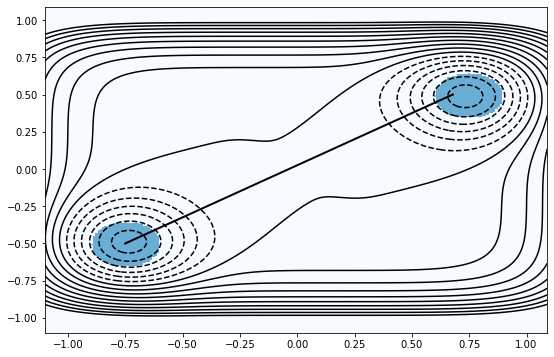

In [13]:
plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, .1)
plot.add_pes(pes_to_plot)
plot.add_states([stateA, stateB])

# passing the initial TP to bold and not to trajectories,
# because we want it to be....bold :)
fig = plot.plot(bold=[tra_to_2d(initAB)])

## aimmd setup

### Create the underlying model to predict/fit the committors
The creation of the model naturally varies depending on the underlying model (in this case a keras ANN) you chose.

In [14]:
from tensorflow.keras import optimizers, regularizers

In [15]:
# use an aimmd utility function to create a pyramidal arch with a ResNet top part
# you could however wrap any keras model that has been compiled with an optimizer in an aimmd RCModel in the next cell
n_lay_pyramid = 3  # number of layers in pyramidal part 
n_unit_top = 5  # width of the top resunits
n_lay_top = 2  # 2 resunits as last layers
n_unit_base = descriptor_transform(template).shape[0]
print('number of input descriptors: ', n_unit_base)

fact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid-1))

hidden_parms = []
for i in range(n_lay_pyramid):
    hidden_parms += [{'units': max(n_unit_top, int(n_unit_base * fact**i)),
                     'activation': 'selu', # elu; selu is good!
                     'use_bias': True,
                     'kernel_initializer': 'lecun_normal',
                     'bias_initializer': 'lecun_normal',
                     'kernel_regularizer': None,#regularizers.l1(l=0.0001),
                     'bias_regularizer': None,
                     'activity_regularizer': None,
                     'kernel_constraint': None,
                     'bias_constraint': None,
                     'dropout': 0.05 * fact**i,
                     }
                    ]
for i in range(n_lay_top):
    
    hidden_parms += [{'units': n_unit_top,
                     'activation': 'elu',
                     'use_bias': True,
                     'kernel_initializer': 'lecun_normal',
                     'bias_initializer': 'lecun_normal',
                     'kernel_regularizer': None,# regularizers.l1(l=0.0001),
                     'bias_regularizer': None,
                     'activity_regularizer': None,
                     'kernel_constraint': None,
                     'bias_constraint': None,
                     'dropout': None,
                     'residual_n_skip': 4,
                     }
                    ]
    

optimizer = optimizers.Adam(lr=0.005) 
# create a ResNet with binomial loss to predict p_B
resnet = aimmd.keras.create_resnet(ndim=n_unit_base, hidden_parms=hidden_parms,
                                  optimizer=optimizer,
                                  n_states=2,  # does not really matter if multi_state=False
                                  multi_state=False)

number of input descriptors:  22


### Wrap the underlying model as `aimmd.RCmodel` 

- The `aimmd.RCModel` and its subclasses is what you will usually be working with when using `aimmd`. It is the expected input for the `aimmd.ops.RCModelSelector` and `aimmd.ops.TrainingHook` classes used for iterative training and also to all analysis methods that can be found in `aimmd.analysis`. Normaly there will be no need for you to access the underlying models, as all `aimmd.RCModels` expose a consistent interface independent of the underlying model. This strict separation enables to easily add other underlying machine learning models to aimmd by subclassing `aimmd.base.rcmodel.RCModel` and simply adding the few required functions to fit the underlying model without the need to reimplement the reinforcement learning decisions.

- The subclass of `aimmd.RCModel` depends on the underlying model(s). All `aimmd.RCModel`s for keras can e.g. be found in `aimmd.keras.rcmodel` but are also imported to the topmodule `aimmd.keras`, such that you can use them as `aimmd.keras.MODEL_CLASS`.


In [16]:
# create aimmd storage
aimmd_store = aimmd.Storage('aimmd_storage.h5')

In [17]:
# we take an ExpectedEfficiencyKerasRCModel,
# this RCmodel scales the learning rate by the expected efficiency factor (1 - n_TP_true / n_TP_expected)**2
model = aimmd.keras.EEScaleKerasRCModel(nnet=resnet, # any keras model predicting a float/a vector of floats,
                                                     # each output will be interpreted as the log probability to reach a certain state
                                                     # if the model only predicts one float it is assumed to be p_B
                                        states=[stateA, stateB],
                                        cache_file=aimmd_store,
                                        descriptor_transform=descriptor_transform,  # the function transforming snapshots to descriptors,
                                                                                    # i.e. the space in which the model learns)
                                        ee_params={'lr_0': 0.005,  # lr = lr_0 * (1 - n_TP_true / n_TP_expected)**2
                                                   'lr_min': 0.0001,  # do not train if lr < lr_min
                                                   'epochs_per_train': 2,  # train for 2 epochs every time we train
                                                   'interval': 5,  # attempt to train after every 5rd MCStep
                                                   'window': 50,  # average expected efficiency factor over 50 MCSteps
                                                   },
                                        )

### Initialize an empty `aimmd.TrainSet`
- The TrainSet is always the same for all RCModels, it stores the shooting points together with corresponding shot_results. It also has some useful methods to iterate over the training data.
- It needs to know about the states, such that it can extract the states reached from given OPS snapshots/trajectories and about the CV transforming molecular coordinates to training descriptors, such that it can calculate and store the training descriptors for each point.

In [18]:
trainset = aimmd.TrainSet(n_states=2)

### create `aimmd` Hooks
These objects handle the interface between openpathsampling and the `aimmd` objects (mainly the `aimmd.RCModel` and the `aimmd.TrainSet`). Currently there are three different hooks:
 - The `aimmd.ops.TrainingHook` trains the model and keeps the `aimmd.TrainSet` up to date, it is required for iterative training to work
 - The `aimmd.ops.AimmdStoragehook` saves the model and the trainset in predefined intervals, it is highly recommended because it is always nice to have a history of models and it enables easy restarts from intermediates if something unexpected happens during the training/simulation
 - The `aimmd.ops.DensityCollectionHook` enabales collection of, and therefore correction for, the density of trajectories in committor space. If it is used the shooting point selection will try to correct for density imbalances in committor space in addition to biasing towards the transition state

In [19]:
trainhook = aimmd.ops.TrainingHook(model, trainset)
storehook = aimmd.ops.AimmdStorageHook(aimmd_store, model, trainset)
densityhook = aimmd.ops.DensityCollectionHook(model)

### create `acrd.ops.RCModelSelector`
This is the object handling the selection of new shooting points according to the current `aimmd.RCModel` prediction. It also calculates (part of) the acceptance factor for the TPS simulation. See `openpathsampling.ShootingPointSelector` for more on shooting point selectors in OPS.

In [20]:
selector = aimmd.ops.RCModelSelector(model=model,  # always takes a RCModel
                                     # we can greatly speed up rejecting/accepting trial TPS by passing the list of states
                                     # this enables testing if a trial TP is a TP and calculating the potentialy costly
                                     # transformation from Cartesian to descriptor space only if neccessary (i.e. if it is a TP and we need to calculate the MC acceptance)
                                     # if we were lazy and knew that the transformation was fast, we could also explicitly pass None
                                     states=[stateA, stateB],
                                     # new shooting points are selected with p_sel(SP) ~ p_lorentz(model.z_sel(SP))
                                     # we could also choose 'gaussian'
                                     distribution='lorentzian',
                                     # softness of the selection distribtion,
                                     # lower values result in a sharper concentration around the predicted transition state,
                                     # higher values result in a more uniform selection
                                     scale=1.0,
                                    )

## setup openpathsampling TPS simulation and storage
This is basic openpathsampling stuff, please consult the openpathsampling examples for details on this section.

In [21]:
# velocity randomizer setup
beta = integ.beta
modifier = paths.RandomVelocities(beta=beta, engine=toy_eng)
# shooting strategy: TwoWayShooting
tw_strategy = paths.strategies.TwoWayShootingStrategy(modifier=modifier, selector=selector, engine=toy_eng, group='TwoWayShooting')
# transition network, tells us which transitions to sample
tps = paths.TPSNetwork.from_states_all_to_all([stateA, stateB])
# move scheme, tells us how to do the sampling
move_scheme = paths.MoveScheme(network=tps)
move_scheme.append(tw_strategy)
# This should always be the last added strategy when constructing custom move_schemes in openpathsampling,
# it sorts all previously appended strategies into a sane hirachy when building the move tree
move_scheme.append(paths.strategies.OrganizeByMoveGroupStrategy())
move_scheme.build_move_decision_tree()

In [22]:
# create initial conditions (initial openpathsampling sample set) from our initial TP
initial_conditions = move_scheme.initial_conditions_from_trajectories([initAB])

No missing ensembles.
No extra ensembles.


In [23]:
# create a storage file
storage = paths.Storage('22dim_toy_keras.nc', 'w', template=template)

In [24]:
# create a PathSampling
sampler = paths.PathSampling(storage=storage,
                             sample_set=initial_conditions,
                             move_scheme=move_scheme
                             )

### aimmd specific again: attach the `TrainHook` to the PathSampling such that it can train after every MCStep

In [25]:
sampler.attach_hook(trainhook)
sampler.attach_hook(storehook)
sampler.attach_hook(densityhook)

In [26]:
# do 1000 MCSteps of TPS
sampler.run(1000)

Working on Monte Carlo cycle number 1000
Running for 25 minutes 44 seconds -  1.55 seconds per step
Estimated time remaining: 1 second


(WARNING)tensorflow: 6 out of the last 11 calls to <function Model.make_train_function.<locals>.train_function at 0x7fc9a010b4c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


DONE! Completed 1000 Monte Carlo cycles.


In [27]:
list(aimmd_store.rcmodels.keys())

['RCModel_after_step_1000', 'RCModel_after_step_500', 'most_recent']

## Lets have a look at the training process

In [28]:
# train log_decision is a list of lists
# every entry contains [train, lr, epochs] as returned by model.train_decision()
print(model.log_train_decision[-1])

[True, 0.00011572345442275381, 2, None]


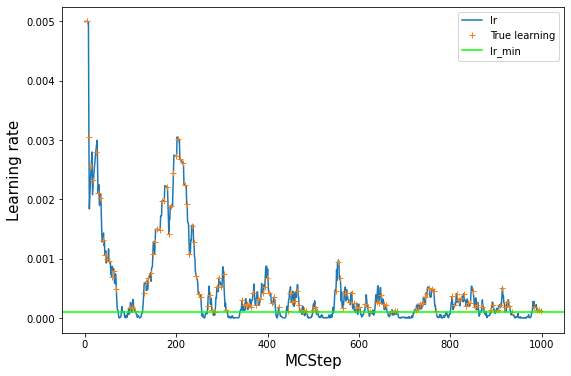

In [29]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

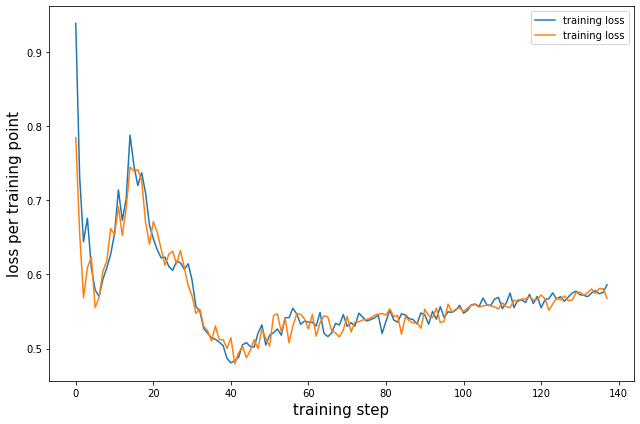

In [30]:
# the model losses at each step where it trained
# this will be epochs_per_training loss values per training
plt.plot(model.log_train_loss, label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('training step', size=15)
plt.tight_layout()

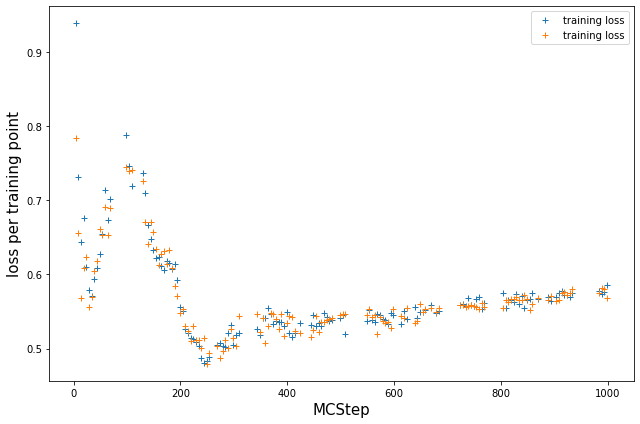

In [31]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

In [34]:
# get the number of accepts from OPS storage
accepts = []
for step in storage.steps:
    if step.change.canonical.accepted:
        accepts.append(1.)
    else:
        accepts.append(0.)

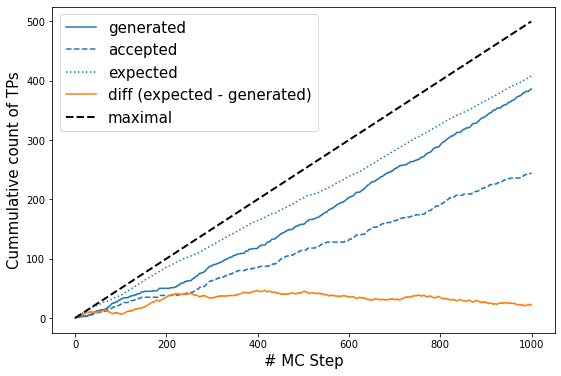

In [35]:
# plot expected and observed number of TPs, also plot the accepted MC moves
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)

p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (expected - generated)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=15);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('# MC Step', size=15);

## look at what the model learned

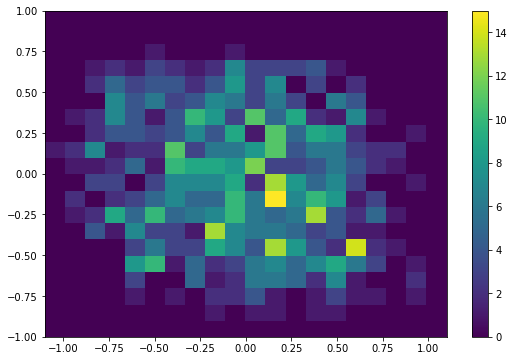

In [36]:
# have a look at the distribution of SPs in the x/y plane
# should show us that the model concentrates the SPs around the transition state in x/y
# Note that this is not really helpful in a molecular setting, as we ussually do not know the projection
# in which the high dimensional descriptor input space reduces to easy relations
# However, for our toy example it can be quite instructive to look at. 

x_vals = np.zeros((len(storage.steps)-1,))
y_vals = np.zeros((len(storage.steps)-1,))
for i, step in enumerate(storage.steps[1:]):
    coords = step.change.canonical.details.shooting_snapshot.coordinates[0]
    x_vals[i] = coords[0]
    y_vals[i] = coords[1]

plt.hist2d(x_vals, y_vals, range=[(-1.1, 1.1),(-1., 1.)], bins=20)
plt.colorbar();

In [37]:
# we can also have a look at the models prediction in x/y
x = np.linspace(-1.2, 1.2, 240)
y = np.linspace(-1., 1., 200)

# we take the hypersurface where all oscillators are 0
oscis = [0. for _ in range(n_harmonics)]
# do one prediction for one big vector and unwrap it afterwards
# this is much faster than looping over the single coordinate points as we can make use of the GPU/CPU vector operations...!
coord = np.array([[xv, yv]  + oscis for yv in y for xv in x])
p = model(coord, use_transform=False)
p = p.reshape((len(y), len(x)))
pred = np.stack([1. - p, p], axis=-1)

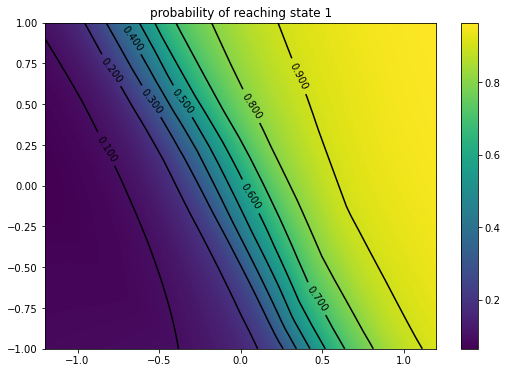

In [38]:
# plot predicted committement probability towards state B
s_num = 1

fig, ax = plt.subplots(1)
im = ax.imshow(pred[...,s_num], origin='lower', extent=(x[0], x[-1], y[0], y[-1]))
levels = np.arange(0., 1., 0.1)
X, Y = np.meshgrid(x, y)
CS = ax.contour(X, Y, pred[..., s_num], levels, colors='k')
ax.clabel(CS, inline=1, fontsize=10, )

ax.set_title('probability of reaching state {:d}'.format(s_num))
fig.colorbar(im);

### HIPR - relative input importance analysis

In [40]:
# perform a HIPR analysis of the model over the trainset
hipr = aimmd.analysis.HIPRanalysis(model,
                                   trainset,
                                   # setting n_redraw=5 will do 5 passses over the randomized training set for every descriptor dimension and average the results 
                                   n_redraw=25,
                                   )

In [41]:
# the HIPR analysis always returns a tuple: the average loss for every coordinate and the standard deviation over the redraws 
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(n_redraw=50)  # hipr plus keeps the distribution of the input descriptors invariant and only permutates them
# the n_redraw argument given to do_hipr_plus()/do_hipr() takes precedence over the one given at init time in case you realize you need a less noisy estimate later

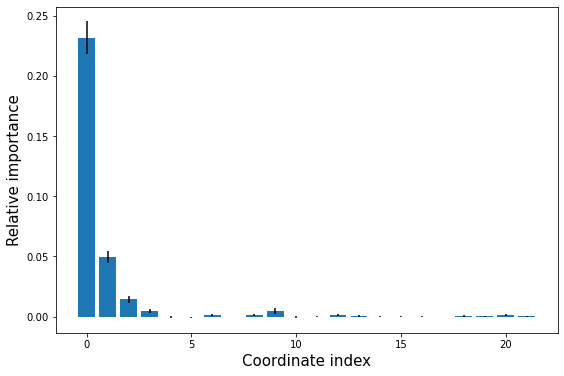

In [43]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_plus_losses[-1] is always the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])  # exclude the last std, it would/will always be zero as it is the std for the reference loss
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [44]:
# sync and close the OPS storage
# not strictly neccessary but a good habit to make sure everything you expect is in there
storage.sync_all()
storage.close()

In [45]:
aimmd_store.close()